## TikTok manuscript data analysis ##

### Linear regression methods (identifies realtionships among continuous variabes) ###

In [4]:
# Import libraries
#   File management
from tkinter import filedialog  # For selecting files
import os  # For directory management
import glob
import shutil
#   Number, file, and image management
from sklearn.linear_model import LinearRegression
import numpy as np  # For array management
import pandas as pd  # For database management
import random
from pandas import Series
#   Plotting results
import matplotlib.pyplot as plt  # For plotting result data
import seaborn as sns
import datetime
import itertools\

### Initial analysis ###

**Step 1: Import TikTok data from specific filepath, set up results directory**

In [5]:
# Local path
file = '/Users/meredithfay/Documents/PROJECT collaborations/Mo/Tiktok data analysis/Tiktok_data.xlsx'
directory = os.path.dirname(file)

In [6]:
# Create a "results" folder within the original directory to save results to
now = datetime.datetime.now()

# Create timestamped results directory
output_folder = os.path.join(directory, 'Regression results, ' + now.strftime("%m_%d_%Y, %H_%M_%S"))
os.mkdir(output_folder)
os.chdir(output_folder)

# Print current working directory
# If you run this cell additional times, multiple directories will be created - results will be in most recent
print(os.getcwd())

/Users/meredithfay/Documents/PROJECT collaborations/Mo/Tiktok data analysis/Regression results, 12_16_2022, 11_08_36


In [7]:
# Read data sheet
sheet = pd.read_excel(file, sheet_name='Data', engine='openpyxl')

In [8]:
# Print columns
print(sheet.columns)  # Some columns will have null values, remove as necessary

Index(['Name:', 'Date', 'Min. followers', 'Follower jump', 'Jump binary',
       'views', 'Video Length (s)', 'Average Watch time (s)',
       'Watched Full Video (%)', 'Reached Audience', 'likes', 'Comments',
       'shares', 'bookmarks', 'Engagement', 'For You (%)', 'Personal Profile',
       'Following (%)', 'Sound (%)', 'hashtag (%)', 'Promoted',
       'How long to film', 'Posted Time', 'David', 'Miku', 'Luyao', 'Mo',
       'Priscilla', 'Anjana', 'Alessandra', 'Adiya', 'Dozie', 'Lily', 'Nina',
       'New followers', 'Category'],
      dtype='object')


In [9]:
# Add column 'Time' representing number of days from start of account
sheet['Time'] = (sheet['Date'] - sheet['Date'].iloc[0]) / np.timedelta64(1, 'D')

In [10]:
# Check data types
sheet.dtypes

Name:                             object
Date                      datetime64[ns]
Min. followers                     int64
Follower jump                      int64
Jump binary                      float64
views                              int64
Video Length (s)                 float64
Average Watch time (s)           float64
Watched Full Video (%)           float64
Reached Audience                 float64
likes                            float64
Comments                           int64
shares                             int64
bookmarks                          int64
Engagement                         int64
For You (%)                      float64
Personal Profile                 float64
Following (%)                    float64
Sound (%)                        float64
hashtag (%)                      float64
Promoted                         float64
How long to film                   int64
Posted Time                       object
David                              int64
Miku            

In [11]:
# Check dataframe
sheet.head(10)

,Name:,Date,Min. followers,Follower jump,Jump binary,views,Video Length (s),Average Watch time (s),Watched Full Video (%),Reached Audience,...,Priscilla,Anjana,Alessandra,Adiya,Dozie,Lily,Nina,New followers,Category,Time
0,Oh no (sound trend),2021-11-05,0,0,NaN,875,34.06,NaN,NaN,NaN,...,0,1,1,0,0,0,0,NaN,1,0.0
1,Full house,2021-11-05,0,0,0.0,2380,61.95,NaN,NaN,NaN,...,1,1,1,1,1,0,0,NaN,3,0.0
2,Joe as a scientist,2021-11-05,0,0,0.0,926,35.11,NaN,NaN,NaN,...,0,0,0,0,1,0,0,NaN,1,0.0
3,P and M dance,2021-11-09,0,0,0.0,1614,10.45,6.3,19.22,2048.0,...,1,0,0,0,0,0,0,NaN,1,4.0
4,day in life of scientist,2021-11-12,0,0,0.0,730,8.33,7.8,53.34,800.0,...,0,0,0,0,0,0,0,NaN,1,7.0
5,PBS,2021-11-13,0,0,0.0,2236,12.74,10.3,47.76,2189.0,...,0,0,0,1,0,0,0,NaN,1,8.0
6,twinnenem,2021-11-16,0,0,0.0,699,12.30,12.3,58.94,660.0,...,0,0,0,0,0,0,0,NaN,1,11.0
7,dirty lab bench,2021-11-19,0,0,0.0,1056,14.12,8.9,24.22,1038.0,...,1,0,0,0,0,0,0,NaN,1,14.0
8,buggin ya boss,2021-11-23,0,0,0.0,674,6.62,8.9,61.86,635.0,...,1,1,1,0,0,0,0,NaN,3,18.0
9,Lab olympics intro,2021-11-27,0,0,0.0,899,38.45,17.5,16.46,841.0,...,1,1,1,1,1,0,0,NaN,3,22.0


#### Sample questions to answer using regression ####

- Followers vs. views: how does number of followers impact (or not impact) view count?
- How does the algorithm work? e.g. does time posted matter? Does length of the video matter?
- Is there a form of engagement (i.e. likes, comments, shares, and/or bookmarks) that matters most to views or channel growth?
- Does relative effort (as quantified by effort to film) result in tangible channel growth or engagement?
- What's unique about promoted videos?
- What's unique about videos that generate a large jump in followers?

### Regression methods begin ###

Series of repeated steps designed to address each question. Steps include:
   - Select relevant columns
   - Plot pairwise relationships between columns
   - If relationships warrant further investigation, label interesting data points with video names
   - Create a linear regression model and fit it
   - Calculate statistics to assess goodness of cluster, i.e. r-squared value
   - Plot data with model line
   - Note interpretation

In [14]:
# Save numerical data to an excel sheet for later additional analysis
# Create excel writer
writer = pd.ExcelWriter('Regression_analysis.xlsx', engine='openpyxl')  # To write excel sheets

In [15]:
# Create dataframe that r values will be saved to
df_rval = pd.DataFrame()

**Question 1: are some categories of videos more popular or impactful than others**

Steps here represent a simple (2-variable) linear regression

In [16]:
# Create a "name" for this analysis for saving files
analysis_name = 'Followers-v-views'

In [17]:
# Select relevant columns from data frame
df = sheet[['Name:', 'Engagement', 'views']]  # Edit, always include "Name:"

# Remove any rows with null values
df = df.dropna(how='any', axis=0)

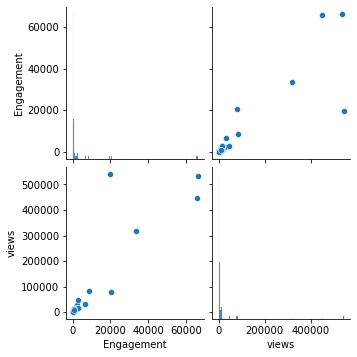

In [18]:
# Plot pairwise relationships between columns
# Display and save a pairplot showing relationships between features
sns.pairplot(df)
plt.savefig(analysis_name + '_pairplot.png', dpi=300)  # Save in results folder
plt.show()

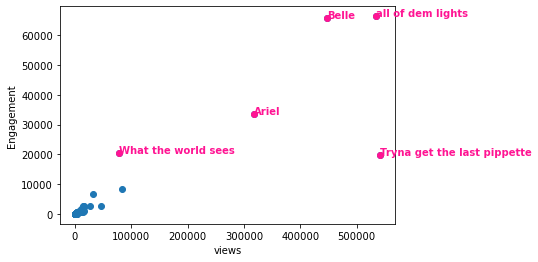

In [72]:
# Label interesting data points with video names
df_subset = df[df['Engagement']>17500]  # Edit condition
x_variable = 'views' # Edit variables
y_variable = 'Engagement'
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.scatter(x=df[x_variable], y=df[y_variable])  # All data points
plt.scatter(x=df_subset[x_variable], y=df_subset[y_variable], color='deeppink')  # Select data points

# Names, need to edit
for i in range(len(df_subset)):
    plt.text(df_subset[x_variable].iloc[i]+0.1, df_subset[y_variable].iloc[i], 
            df_subset['Name:'].iloc[i], horizontalalignment='left', size='medium', color='deeppink', weight='semibold')
        
plt.savefig(analysis_name + '_labeled-points.png', dpi=300)
plt.show()

In [28]:
# Create a linear regression model and fit it
model = LinearRegression()
X = df[x_variable].to_numpy().reshape(-1, 1)
Y = df[y_variable].to_numpy().reshape(-1, 1)
model.fit(X, Y)

LinearRegression()

In [73]:
# Calculate regression score and characteristics, save to list that will be saved as final analysis sheet
# r_sq approaching 1 indicates good fit
r_sq = model.score(X, Y)
print(f"R-squared value: {r_sq}")

intercept = model.intercept_
print(f"Intercept: {intercept[0]}")

slope = model.coef_
print(f"Slope: {slope[0][0]}")

dict_rs = {"Analysis name":analysis_name, "R-squared value":r_sq,
          'Intercept':intercept[0], 'Slope':slope[0][0]}  # Dict
dict_df = pd.DataFrame(dict_rs, index=[0])  # Dataframe
df_rval = df_rval.append(dict_df, ignore_index=True)

R-squared value: 0.8051797090558771
Intercept: 214.15076116457885
Slope: 0.09853317458585459


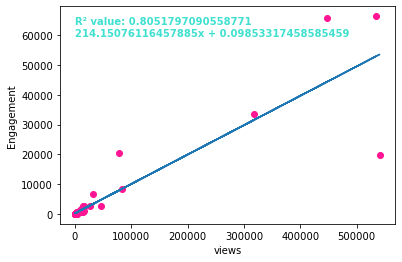

In [71]:
# Plot data points and linear regression line on a plot
plt.scatter(x=df[x_variable], y=df[y_variable], color='deeppink')  # All data points
plt.plot(df[x_variable], slope[0][0]*df[x_variable]+intercept[0])
plt.xlabel(x_variable)
plt.ylabel(y_variable)
line_text = f"R\u00b2 value: {r_sq}\n{intercept[0]}x + {slope[0][0]}"
plt.annotate(line_text, xy=(df[x_variable].min(), df[y_variable].max()-df[y_variable].max()/10), size='medium', color='turquoise', weight='semibold')
plt.savefig(analysis_name + '_simple-regression.png', dpi=300)
plt.show()

**Note interpretation for later reference**
- There's a direct relationship between views and engagement

**Question 2: is there a form of engagement (i.e. likes, comments, shares, and/or bookmarks) that matters most to views or channel growth?**

Steps here represent a multivariate linear regression

In [75]:
# Create a "name" for this analysis for saving files
analysis_name = 'Engagement-type'

In [76]:
# Select relevant columns from data frame
df = sheet[['Name:', 'views', 'likes', 'Comments', 'shares', 'bookmarks']]  # Edit, always include "Name:"

# Remove any rows with null values
df = df.dropna(how='any', axis=0)

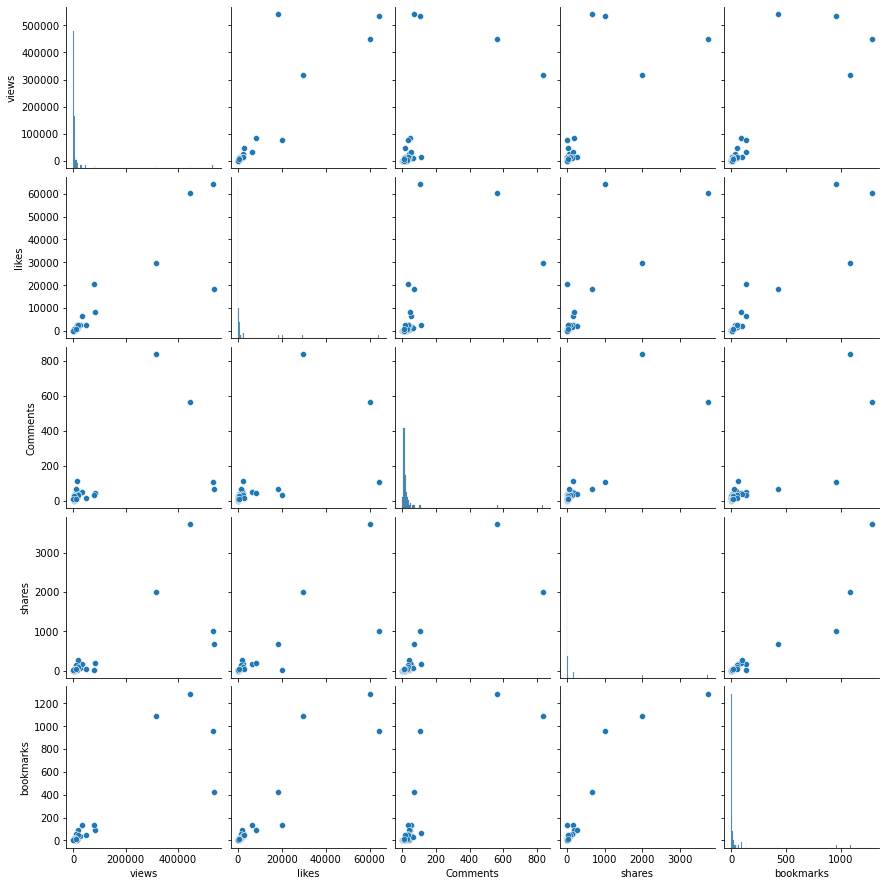

In [77]:
# Plot pairwise relationships between columns
# Display and save a pairplot showing relationships between features
sns.pairplot(df)
plt.savefig(analysis_name + '_pairplot.png', dpi=300)  # Save in results folder
plt.show()

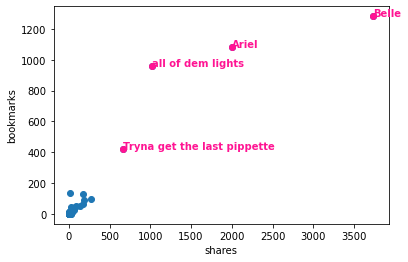

In [78]:
# Label interesting data points with video names
df_subset = df[df['bookmarks']>250]  # Edit condition
x_variable = 'shares' # Edit variables
y_variable = 'bookmarks'
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.scatter(x=df[x_variable], y=df[y_variable])  # All data points
plt.scatter(x=df_subset[x_variable], y=df_subset[y_variable], color='deeppink')  # Select data points

# Names, need to edit
for i in range(len(df_subset)):
    plt.text(df_subset[x_variable].iloc[i]+0.1, df_subset[y_variable].iloc[i], 
            df_subset['Name:'].iloc[i], horizontalalignment='left', size='medium', color='deeppink', weight='semibold')
        
plt.savefig(analysis_name + '_labeled-points.png', dpi=300)
plt.show()

In [83]:
# Create a linear regression model and fit it
model = LinearRegression()
# For multivariate analysis: several x variables, one y variable
y_block = 'views'  # Column name for y block, all remaining variables are x block variables
Y = df[y_block]
X = df.drop(columns=[y_block, 'Name:'])

model.fit(X, Y)

LinearRegression()

In [89]:
# Calculate regression score and characteristics, save to list that will be saved as final analysis sheet
# r_sq approaching 1 indicates good fit
r_sq = model.score(X, Y)
print(f"R-squared value: {r_sq}")

intercept = model.intercept_
print(f"Intercept: {intercept}")

slope = model.coef_
print(f"Slope: {slope}")

dict_rs = {"Analysis name":analysis_name, "R-squared value":r_sq,
          'Intercept':intercept, 'Slope':[slope]}  # Dict
dict_df = pd.DataFrame(dict_rs, index=[0])  # Dataframe
df_rval = df_rval.append(dict_df, ignore_index=True)

R-squared value: 0.9035819347911949
Intercept: 15153.96563644887
Slope: [  -8.05807793 -891.3650803   -78.08317184 1343.21096797]


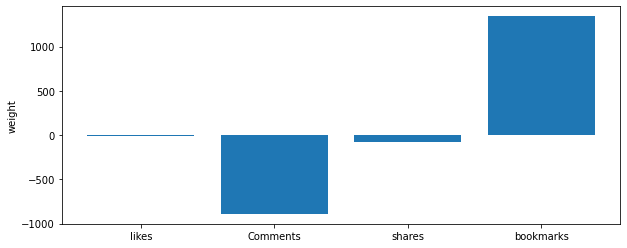

In [93]:
# Plot weights assigned to each feature
plt.figure(figsize=(10, 4))
plt.bar(X.columns, model.coef_)
plt.ylabel('weight')
plt.savefig(analysis_name + '_regr-weights.png', dpi=300)
plt.show()

**Note interpretation for later reference**
- An increased number of bookmarks indicate a video is getting views. Comments are not associated with more views.

**Final steps**

In [39]:
# Save silhoutte scores
df_rval.to_excel(writer, sheet_name='Regression info.', index=False)

In [65]:
# Save and close writer to export results excel
writer.save()
writer.close()

**Comments, questions, or concerns?** Check us out at @scieneers on tiktok and stay tuned for our peer-reviewed manuscript celebrating one year of outreach! In the meantime, please feel free to contact me at meredith.e.fay@gmail.com